# **Analysing purchasing behaviours using classification and clustering techniques**

---
This notebook contains the following sections:

1. Exploratory Data Analysis
    *   Understanding the dataset and feature distribution
    *   Identifying outliers and Correlations
2. Data Preprocessing
    *   Outlier Removal using Z-score method
    *   Handling Multicollinearity
    *   Skew correction using Yeo-Johnson Transformation
    *   Feature Scaling using StandardScalar
3. Unsupervised Learning
    *  K-Means Clustering
        * Determining Optimal K using Elbow and Silhouette methods
        * Cluster Visualisation using 2D/3D PCA, radar chart and Parallel Plots
        * Interpret cluster centroids and business profiles
    *  Hierarchical Clustering
        * Evaluate Linkage Methods
        * Dendrogram Analysis and Cluster Selection
        * Cluster Visualisations and Profiling
4. Supervised Learning
    *   Region Classification using Support Vector Machine
        *  Model Training and Fine-tuning using SMOTE and GridSearch CV
        *  Evaluate model using Accuracy, F1 and ROC-AUC metrics
        *  Visualise ROC curve for each region and aggregate performance
---

In [1]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D  # for 3D PCA visualization

# Preprocessing and Clustering
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, PowerTransformer, label_binarize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Supervised Learning and Evaluation
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, roc_auc_score
)

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter

In [2]:
from google.colab import drive  # Import the drive module from Colab
drive.mount('/content/drive')   # Mount Google Drive to this directory

Mounted at /content/drive


In [5]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Datasets/Wholesale_dataset.csv")

# **Exploratory Data Analysis (EDA)**

## Understanding the Dataset and Feature Distribution

In [6]:
#Checking the shape of the dataset
df.shape

(440, 7)

In [7]:
#Displaying the first 5 rows of the dataset
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper
0,2,3,12669,9656,7561,214,2674
1,2,3,7057,9810,9568,1762,3293
2,2,3,6353,8808,7684,2405,3516
3,1,3,13265,1196,4221,6404,507
4,2,3,22615,5410,7198,3915,1777


In [8]:
#Check for null values
df.isna().sum()

,0
Channel,0
Region,0
Fresh,0
Milk,0
Grocery,0
Frozen,0
Detergents_Paper,0


In [9]:
#Check for duplicate values
df.duplicated().sum()

np.int64(0)

In [10]:
#Describe the dataset
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000


In [11]:
#Check the region labels
print("Region labels: ", df['Region'].unique())
print("Region Count: ", df['Region'].value_counts())

Region labels:  [3 1 2]
Region Count:  Region
3    316
1     77
2     47
Name: count, dtype: int64


In [12]:
#Check the channel labels
print("Channel labels: ", df['Channel'].unique())
print("Channel Count: ", df['Channel'].value_counts())

Channel labels:  [2 1]
Channel Count:  Channel
1    298
2    142
Name: count, dtype: int64


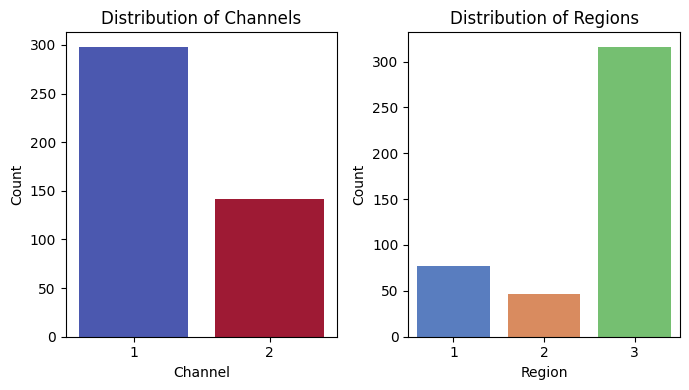

In [13]:
# Create histograms (count plots) for Channel and Region
plt.figure(figsize=(7,4))

# Channel distribution
plt.subplot(1,2,1)
sns.countplot(data=df, x='Channel', hue='Channel', palette='coolwarm', legend=False)
plt.title('Distribution of Channels')
plt.xlabel('Channel')
plt.ylabel('Count')

# Region distribution
plt.subplot(1,2,2)
sns.countplot(data=df, x='Region', hue='Region', palette='muted', legend=False)
plt.title('Distribution of Regions')
plt.xlabel('Region')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

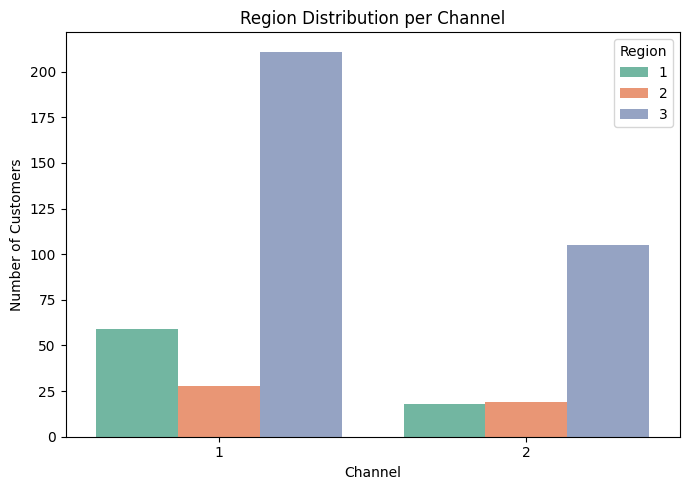

In [14]:
#Plotting the Region distribution per Channel
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Channel', hue='Region', palette='Set2')
# Add titles and labels
plt.title('Region Distribution per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Customers')
plt.legend(title='Region', loc='upper right')
plt.tight_layout()
plt.show()

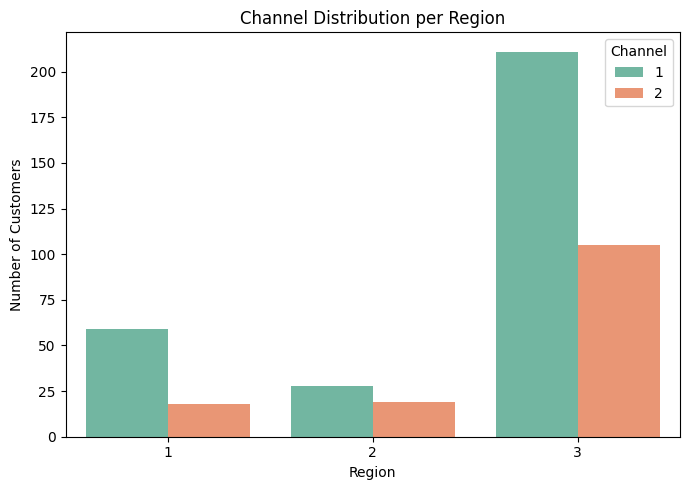

In [15]:
#Plotting the Channel distribution per Region
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Region', hue='Channel', palette='Set2')
# Add titles and labels
plt.title('Channel Distribution per Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.legend(title='Channel', loc='upper right')
plt.tight_layout()
plt.show()

### Identifying outliers and Correlations

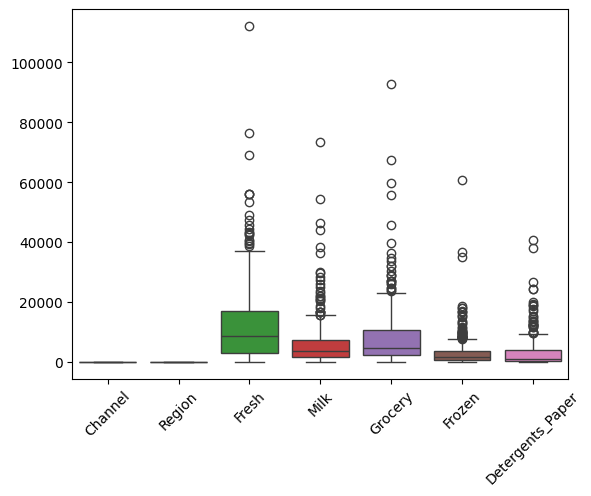

In [16]:
#Boxplot to visualise outliers
sns.boxplot(df)
plt.xticks(rotation=45)
plt.show()

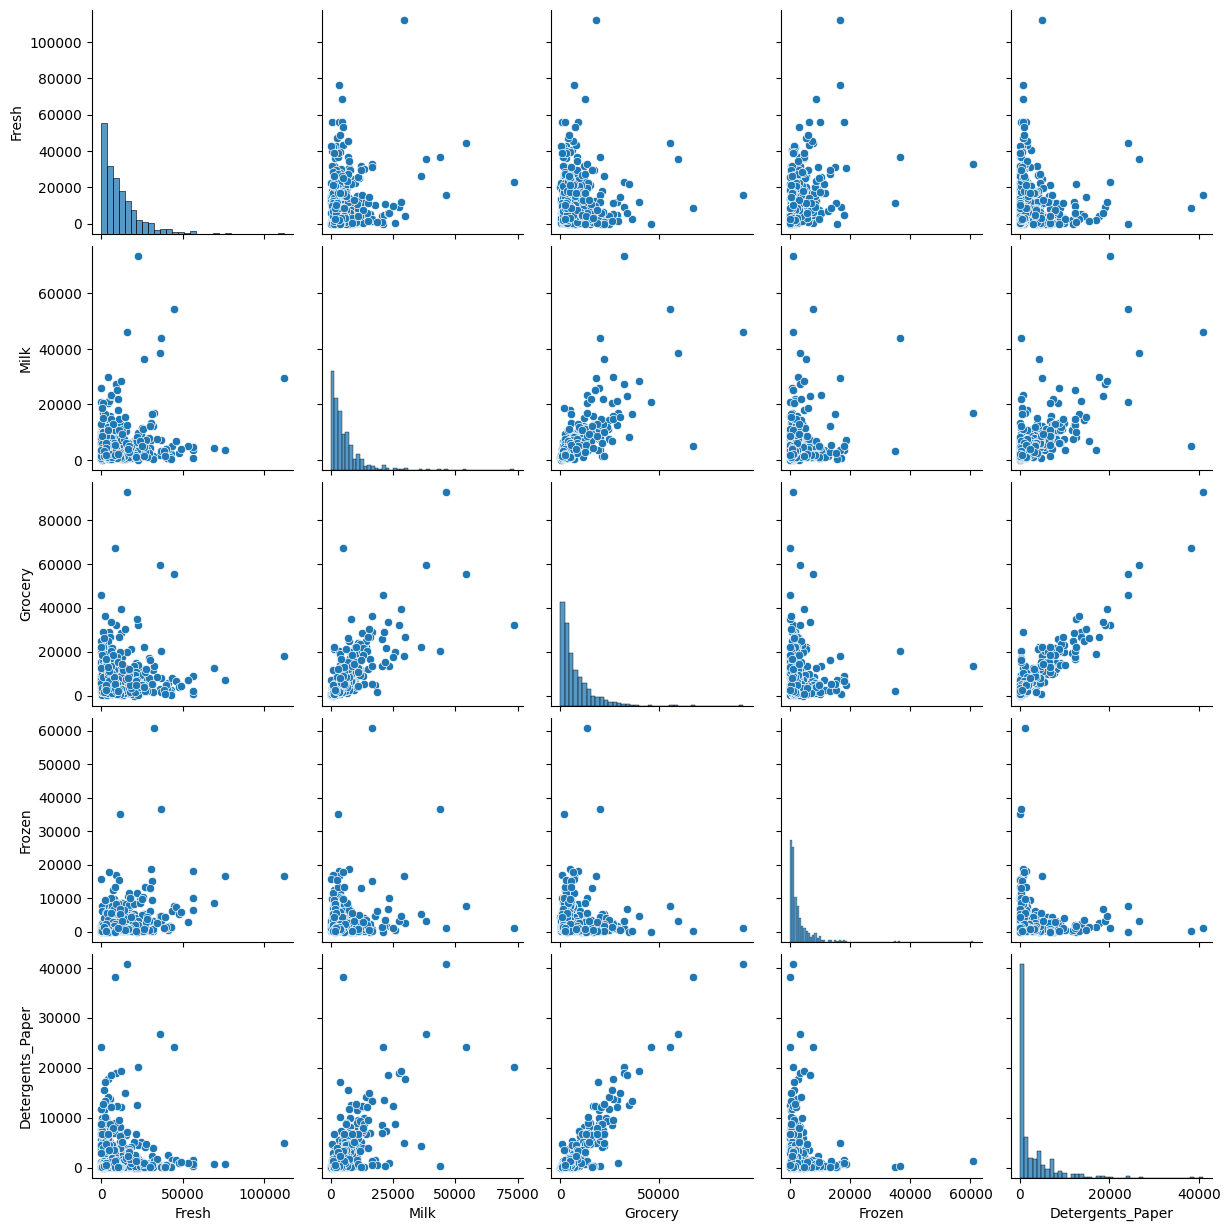

In [17]:
#Plotting the pairwise distribution of numerical features
sns.pairplot(df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']])
plt.show()

In [18]:
#Checking the numerical features for correlation
features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']
df[features].corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953
Milk,0.100510,1.000000,0.728335,0.123994,0.661816
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000


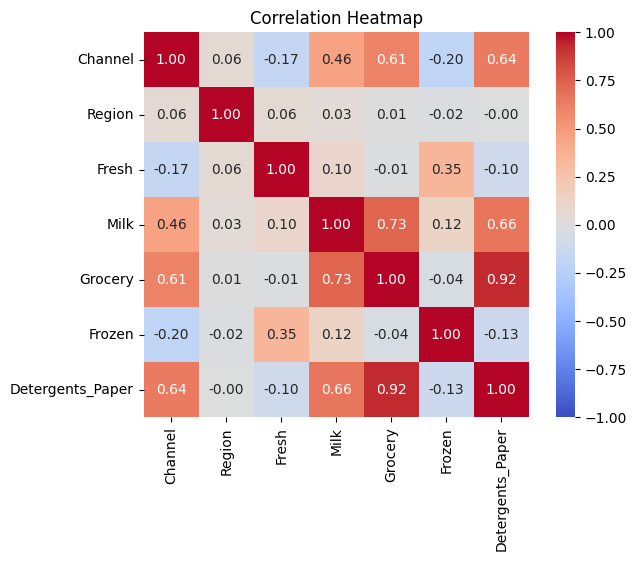

In [19]:
#Plotting the Correlation Heatmap
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), annot=True, fmt=".2f", square=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [20]:
# Compute variance for the numerical features
variances = df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']].var()
print(variances)

Fresh               1.599549e+08
Milk                5.446997e+07
Grocery             9.031010e+07
Frozen              2.356785e+07
Detergents_Paper    2.273244e+07
dtype: float64


# **Data Preprocessing**

In [21]:
# Keep Channel and Region labels separately for later analysis
channel = df['Channel']
region = df['Region']

# Create a new DataFrame containing only the spending features for clustering
X = df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']]

### Outlier Removal using Z-score method

In [22]:
#Outlier Detection and Removal using Z-Score
z_scores = np.abs(stats.zscore(X))
mask = (z_scores < 3).all(axis=1)

# Apply the mask to filter out outliers from the main dataset and supporting variables
df_clean = df[mask].copy()
channel_clean = channel[mask]
region_clean = region[mask]
X_clean = X[mask]

print("Original shape:", df.shape)
print("After removing outliers:", df_clean.shape)
print("Count of channel_clean: ", channel_clean.value_counts().sum())
print("Count of region_clean: ", region_clean.value_counts().sum())
print("Shape of the dataframe for clustering:", X_clean.shape)

Original shape: (440, 7)
After removing outliers: (416, 7)
Count of channel_clean:  416
Count of region_clean:  416
Shape of the dataframe for clustering: (416, 5)


### Handling Multicollinearity

In [23]:
#Dropping the feature Detergents_Paper to remove multicollinearity
X_clean_reduced = X_clean.drop(columns=['Detergents_Paper'])

### Skew Correction using Yeo-Johnson Transformation

In [24]:
# Compute the skewness for each numerical feature after removing 'Detergents_Paper'.
# Skewness measures how much the distribution deviates from symmetry
X_clean_reduced.skew()

,0
Fresh,1.360505
Milk,1.734094
Grocery,1.530661
Frozen,2.110994


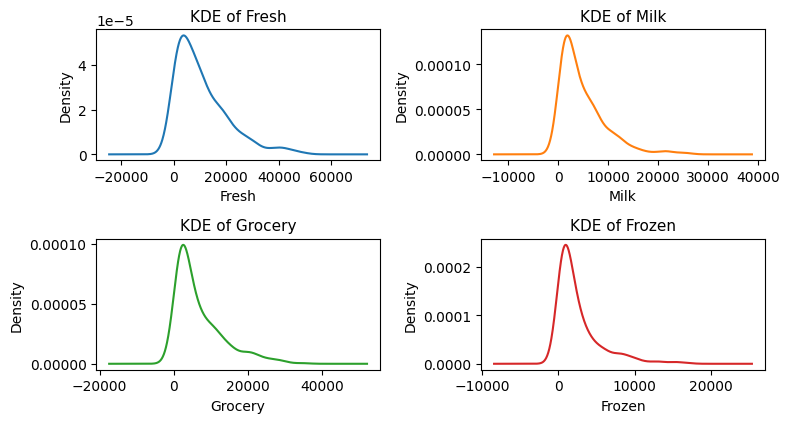

In [25]:
# Plot KDE (Kernel Density Estimate) for each feature to visualize distribution shapes
axes = X_clean_reduced.plot(
    kind='kde',
    subplots=True,
    layout=(3, 2),
    figsize=(8, 6),
    sharex=False,
    sharey=False,
    legend=False
)

# Add titles and labels
for ax, col in zip(axes.flat, X_clean_reduced.columns):
    ax.set_title(f"KDE of {col}", fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

In [26]:
 #Apply Yeo-Johnson transformation to reduce skewness
pt = PowerTransformer(method='yeo-johnson')
X_yeo = pd.DataFrame(pt.fit_transform(X_clean_reduced), columns=X_clean_reduced.columns)

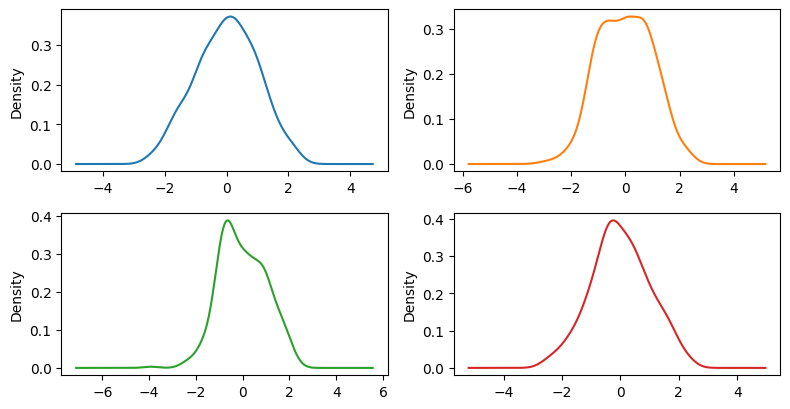

In [27]:
# Plot KDE (Kernel Density Estimate) for each feature to visualize distribution shapes
xes = X_yeo.plot(
    kind='kde',
    subplots=True,
    layout=(3, 2),
    figsize=(8, 6),
    sharex=False,
    sharey=False,
    legend=False
)

# Add titles and labels
for ax, col in zip(axes.flat, X_yeo.columns):
    ax.set_title(f"KDE of {col}", fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

### Feature Scaling

In [28]:
# Standardize Features for Clustering
# StandardScaler transforms features so each has mean = 0 and std = 1.
scaler = StandardScaler()
# Fit the scaler on Yeo-Johnson transformed data and apply scaling
X_scaled = scaler.fit_transform(X_yeo)

In [29]:
# Save the pre processed dataset as CSV
X_scaled_df = pd.DataFrame(X_scaled, columns=X_clean_reduced.columns)
X_scaled_df.to_csv("/content/drive/MyDrive/Uni/CSE5DMI/preprocessed_features.csv", index=False)

print("Preprocessed dataset saved successfully.")

Preprocessed dataset saved successfully.


# **Unsupervised Learning - KMeans and Hierarchical**

# KMeans Clustering

### Determining Optimal K using Elbow and Silhouette methods



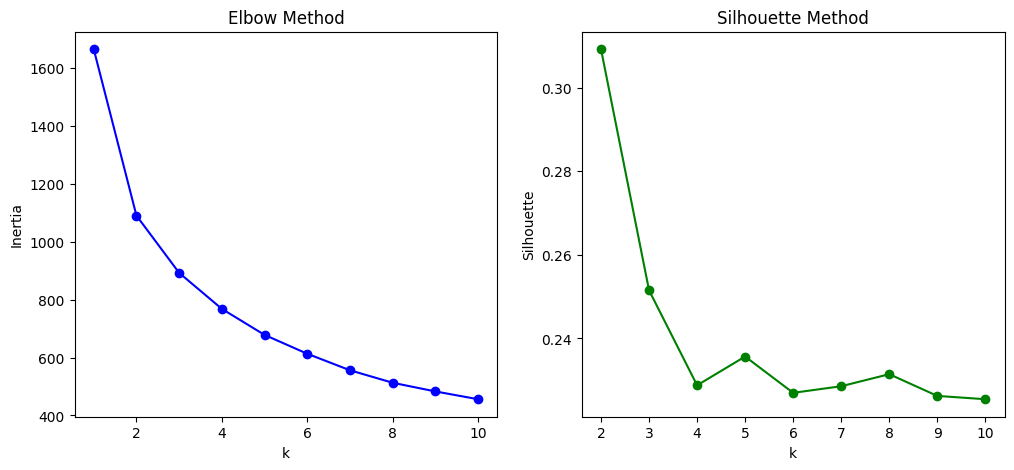

Best Silhouette score: 0.31
Optimal k = 2


In [30]:
# Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []
K = range(1, 11)

# Iterate through possible cluster numbers
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

    # Silhouette score is valid only for k > 1
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    else:
        silhouette_scores.append(np.nan)

# Plot the Elbow and Silhouette methods
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Silhouette Method')

plt.show()

# Print best silhouette score and corresponding optimal k
print('Best Silhouette score:', np.nanmax(silhouette_scores).round(2))
optimal_k = K[np.nanargmax(silhouette_scores)]
print(f"Optimal k = {optimal_k}")

In [31]:
# Fit the K-Means model using the optimal number of clusters determined earlier
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)

# Predict cluster labels for each observation in the scaled dataset
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Add the predicted cluster labels as a new column in the cleaned dataset
df_clean.loc[:, 'KMeans_Cluster'] = kmeans_labels

# Display the first few rows to confirm the addition of cluster labels
print(df_clean.head())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669  9656     7561     214              2674   
1        2       3   7057  9810     9568    1762              3293   
2        2       3   6353  8808     7684    2405              3516   
3        1       3  13265  1196     4221    6404               507   
4        2       3  22615  5410     7198    3915              1777   

   KMeans_Cluster  
0               0  
1               0  
2               0  
3               1  
4               1  


### Cluster Visualisation with 2D/3D PCA

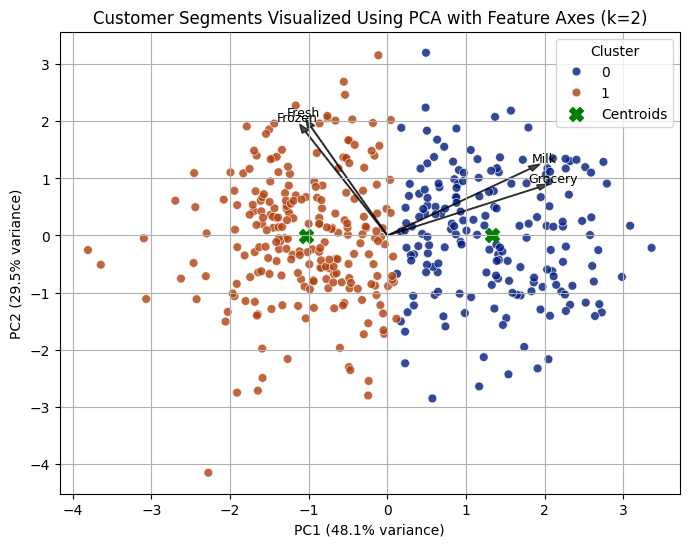

Explained variance by PC1 and PC2: [0.48130121 0.29529157]


In [32]:
# 2D PCA Visualization of K-Means Clusters with Feature Axes

# Perform PCA (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create PCA result DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

# Transform cluster centroids to PCA space
centroids_pca = pca.transform(kmeans_final.cluster_centers_)

# Scatter plot with clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2',
                hue='Cluster', palette='dark', s=40, alpha=0.8)

# Plot centroids
plt.scatter(centroids_pca[:,0], centroids_pca[:,1],
            c='green', s=100, marker='X', label='Centroids')

# Feature Axes (Loadings)
loadings = pca.components_.T  # shape: (n_features, n_components)
features = list(X.columns[:loadings.shape[0]])  # match shape safely

scaling_factor = 3  # arrow length multiplier

for i in range(loadings.shape[0]):
    plt.arrow(0, 0,
              loadings[i, 0]*scaling_factor,
              loadings[i, 1]*scaling_factor,
              color='black', alpha=0.7, width=0.01, head_width=0.1)
    plt.text(loadings[i, 0]*(scaling_factor + 0.3),
             loadings[i, 1]*(scaling_factor + 0.3),
             features[i], color='black', fontsize=9, ha='center')

# Plot Details
plt.title(f'Customer Segments Visualized Using PCA with Feature Axes (k={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print("Explained variance by PC1 and PC2:", pca.explained_variance_ratio_)


In [33]:
# Fit PCA with 3 principal components to capture more variance for visualization
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

# Display the proportion of variance explained by each component
print("Explained variance by PC1, PC2, and PC3:", pca.explained_variance_ratio_)

# Display the cumulative variance explained by the three components
print("Cumulative variance explained:", pca.explained_variance_ratio_.sum())

Explained variance by PC1, PC2, and PC3: [0.48130121 0.29529157 0.16440054]
Cumulative variance explained: 0.9409933274053074


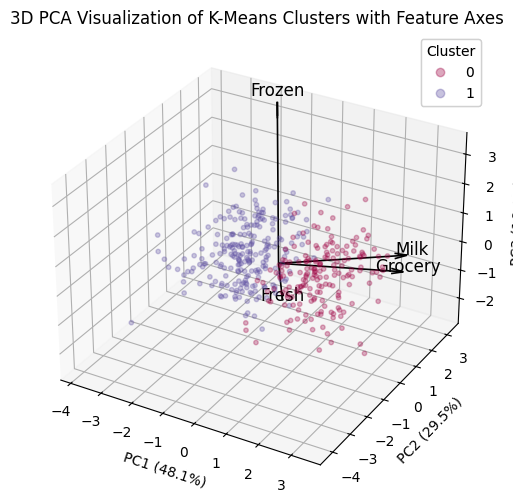

In [34]:
# Create 3D PCA for visualizing K-Means clusters with feature axes
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: customer data points in 3D PCA space, colored by cluster
scatter = ax.scatter(
    X_pca_3d[:, 0],  # PC1
    X_pca_3d[:, 1],  # PC2
    X_pca_3d[:, 2],  # PC3
    c=df_clean['KMeans_Cluster'],
    cmap='Spectral',
    s=10,
    alpha=0.3
)

# Add feature axes (loadings)
loadings = pca.components_.T  # Shape (n_features, n_components)
features = list(X.columns[:loadings.shape[0]])
scaling_factor = 5  # Arrow length multiplier

for i in range(loadings.shape[0]):
    ax.quiver(0, 0, 0,
              loadings[i, 0] * scaling_factor,
              loadings[i, 1] * scaling_factor,
              loadings[i, 2] * scaling_factor,
              color='black', linewidth=1.2, arrow_length_ratio=0.1)
    ax.text(loadings[i, 0] * (scaling_factor + 0.2),
            loadings[i, 1] * (scaling_factor + 0.2),
            loadings[i, 2] * (scaling_factor + 0.2),
            features[i], color='black', fontsize=12, ha='center')

# Label axes with explained variance
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('3D PCA Visualization of K-Means Clusters with Feature Axes')

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Cluster", loc="best")
ax.add_artist(legend)

plt.show()

### Interpret Cluster Centroids and Business Profiles

In [35]:
# Display the relationship between K-Means clusters and customer channels
print("\nCluster vs Channel distribution :")

# Create a cross-tabulation table showing the count of customers per Channel within each cluster
cross_tab_channel = pd.crosstab(df_clean['KMeans_Cluster'], channel_clean)

# Display the cross-tabulation table in a clean, readable format
display(cross_tab_channel)


Cluster vs Channel distribution :


Channel,1,2
KMeans_Cluster,,
0,65,118
1,221,12


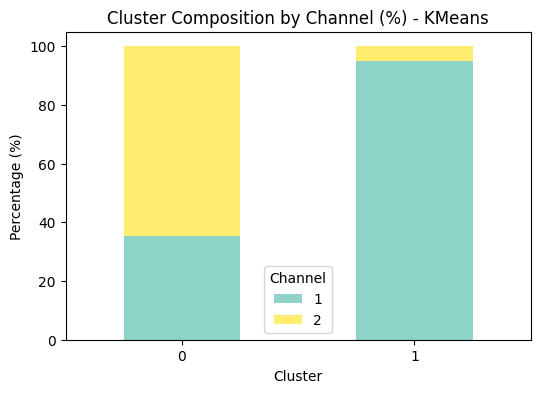

In [36]:
# Create a percentage cross-tab to show the proportion of each Channel within every K-Means cluster
cross_tab_channel = pd.crosstab(
    df_clean['KMeans_Cluster'],
    df_clean['Channel'],
    normalize='index'
) * 100  # Convert proportions to percentages

# Plot the percentage distribution of Channels across clusters
cross_tab_channel.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 4),
    colormap='Set3'
)

# Add plot details for clarity
plt.title("Cluster Composition by Channel (%) - KMeans")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.legend(title="Channel")
plt.xticks(rotation=0)
plt.show()

In [37]:
# Display the relationship between K-Means clusters and customer regions
print("\nCluster vs Region distribution :")

# Create a cross-tabulation table showing the count of customers per Region within each cluster
cross_tab_region = pd.crosstab(df_clean['KMeans_Cluster'], region_clean)

# Display the table rounded to two decimal places for better readability
display(cross_tab_region.round(2))


Cluster vs Region distribution :


Region,1,2,3
KMeans_Cluster,,,
0,29,18,136
1,42,27,164


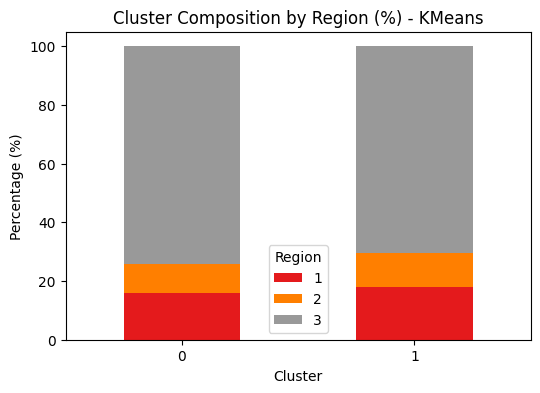

In [38]:
# Create a percentage cross-tab to show the proportion of each Region within every K-Means cluster
cross_tab_region = pd.crosstab(
    df_clean['KMeans_Cluster'],
    df_clean['Region'],
    normalize='index'
) * 100  # Convert proportions to percentages

# Plot the percentage distribution of Regions across clusters
cross_tab_region.plot(
    kind='bar',
    stacked=True,
    figsize=(6, 4),
    colormap='Set1'
)

# Add plot details for better interpretation
plt.title("Cluster Composition by Region (%) - KMeans")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.legend(title="Region")
plt.xticks(rotation=0)
plt.show()

In [39]:
# Calculate the average spending for each product category within each K-Means cluster
df_clean.groupby('KMeans_Cluster')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']].mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper
KMeans_Cluster,,,,,
0,7333.885246,8292.153005,11839.174863,1390.131148,4669.939891
1,13537.008584,2170.824034,2933.922747,3489.051502,573.982833


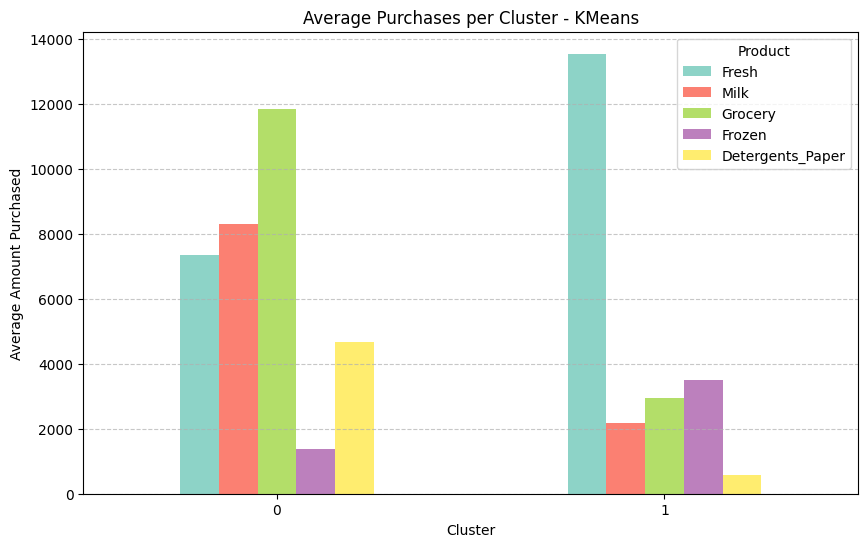

In [40]:
# Compute the mean spending on each product category for every K-Means cluster
cluster_means = df_clean.groupby('KMeans_Cluster')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']].mean()

# Plot the average spending per cluster to visualize customer purchasing patterns
cluster_means.plot(
    kind='bar',
    figsize=(10, 6),
    colormap='Set3'
)

# Add plot labels and formatting for better readability
plt.title("Average Purchases per Cluster - KMeans")
plt.xlabel("Cluster")
plt.ylabel("Average Amount Purchased")
plt.xticks(rotation=0)
plt.legend(title="Product")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

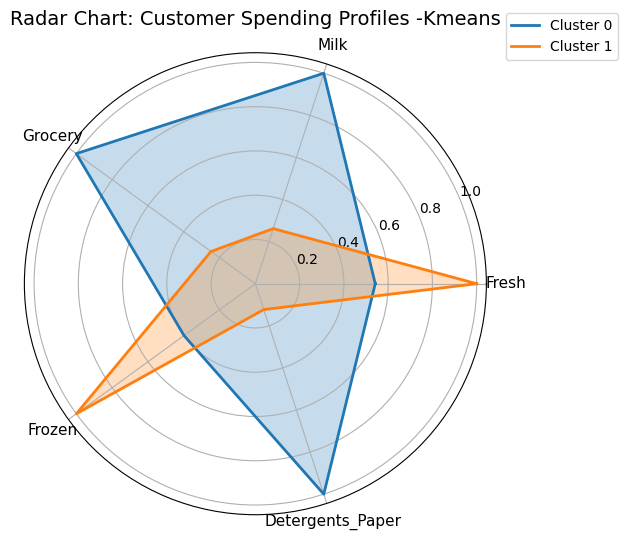

In [41]:
# Compute cluster means
cluster_means = df_clean.groupby('KMeans_Cluster')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']].mean()

# Normalize values to improve shape comparability
cluster_means_norm = cluster_means / cluster_means.max()

# Define labels and number of variables
categories = cluster_means_norm.columns
N = len(categories)

# Calculate angles for each axis
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Create plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster
for i in range(len(cluster_means_norm)):
    values = cluster_means_norm.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

# Add feature labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_title("Radar Chart: Customer Spending Profiles -Kmeans", size=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


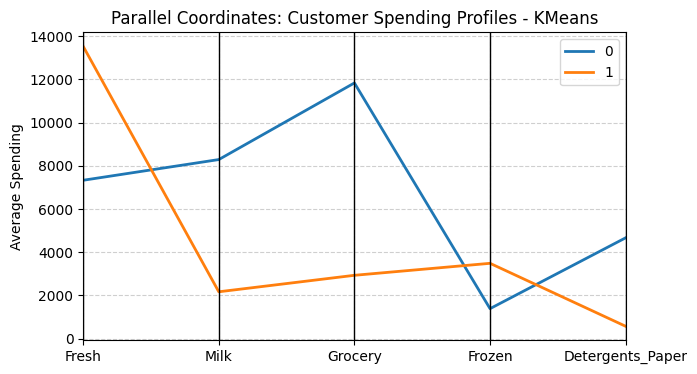

In [42]:
# Prepare cluster mean data for parallel coordinates plotting
cluster_means_reset = cluster_means.reset_index()  # Reset index for easier plotting
cluster_means_reset['KMeans_Cluster'] = cluster_means_reset['KMeans_Cluster'].astype(str)  # Convert cluster labels to string

# Create a parallel coordinates plot to compare average spending patterns across clusters
plt.figure(figsize=(7, 4))
parallel_coordinates(
    cluster_means_reset,
    class_column='KMeans_Cluster',  # Use cluster label as grouping variable
    cols=['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper'],  # Features to plot
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Distinct colors for each cluster
    linewidth=2
)

# Add plot title and labels
plt.title("Parallel Coordinates: Customer Spending Profiles - KMeans")
plt.ylabel("Average Spending")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Hierarchical Clustering

### Evaluate Linkage Methods -'ward', 'complete' and 'average'

In [43]:
# Evaluate different linkage methods for Hierarchical Clustering
for linkage_method in ['ward', 'complete', 'average']:
    # Compute the hierarchical linkage matrix using the specified method
    Z = linkage(X_scaled, method=linkage_method)

    # Extract the distances between merged clusters
    distances = Z[:, 2]

    # Compute the differences between consecutive merge distances
    diffs = np.diff(distances)

    # Identify the largest jump (gap) in distances — used to estimate optimal cut threshold
    largest_gap_idx = np.argmax(diffs)
    threshold = (distances[largest_gap_idx] + distances[largest_gap_idx + 1]) / 2

    # Apply Agglomerative Clustering using the determined threshold
    labels = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=threshold,
        linkage=linkage_method
    ).fit_predict(X_scaled)

    # Calculate the Silhouette Score to assess cluster quality
    score = silhouette_score(X_scaled, labels)

    # Print the Silhouette Score for each linkage method
    print(f"{linkage_method}: {score:.3f}")


ward: 0.280
complete: 0.179
average: 0.200


### Dendrogram Analysis and Cluster Selection

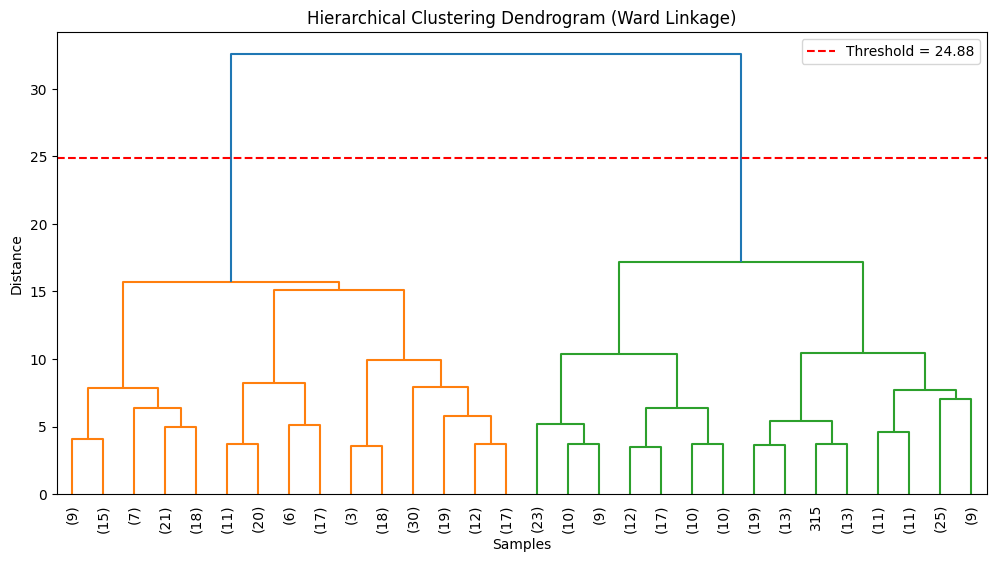

In [44]:
# Perform Hierarchical Clustering using the Ward linkage method
Z = linkage(X_scaled, method='ward')

# Extract the linkage distances between merged clusters
distances = Z[:, 2]

# Compute the difference between consecutive merge distances
diffs = np.diff(distances)

# Identify the largest jump in distance (used to determine the optimal cut threshold)
largest_gap_idx = np.argmax(diffs)
threshold = (distances[largest_gap_idx] + distances[largest_gap_idx + 1]) / 2

# Plot the dendrogram with a red dashed line showing the cut threshold
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    truncate_mode='lastp',          # Show only the last few merged clusters
    leaf_rotation=90,               # Rotate leaf labels for readability
    leaf_font_size=10,              # Font size for leaf labels
    color_threshold=threshold       # Color branches based on threshold
)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.legend()
plt.show()

# Apply Agglomerative Clustering using the computed threshold
hier_clust = AgglomerativeClustering(
    n_clusters=None,                # Let the model determine clusters based on distance threshold
    distance_threshold=threshold,   # Use threshold derived from dendrogram
    linkage='ward'                  # Same linkage method as above
)

# Fit the model and assign cluster labels to each sample
hier_labels = hier_clust.fit_predict(X_scaled)

# Store the cluster assignments in the main dataframe
df_clean['HierCluster'] = hier_labels

In [45]:
# Display the unique cluster labels generated by hierarchical clustering
print(df_clean['HierCluster'].unique())

[1 0]


### Cluster Visualisations using 2D/3D PCA

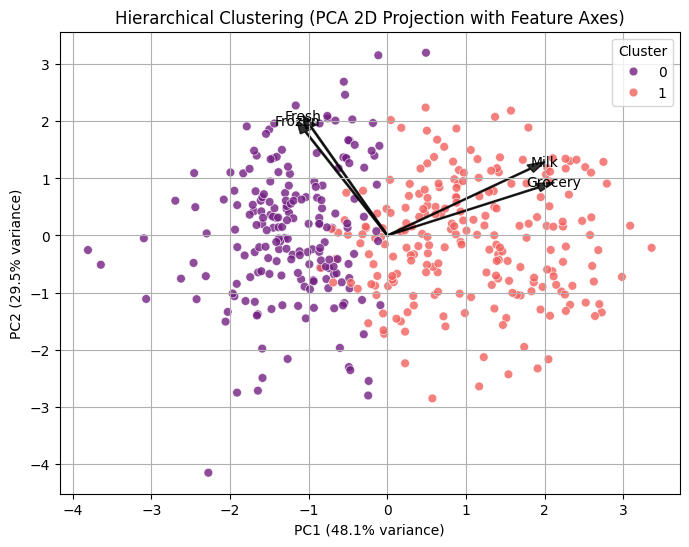

Explained variance by PC1 and PC2: [0.48130121 0.29529157]


In [46]:
# PCA and Data Preparation
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df_hier = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df_hier['HierCluster'] = hier_labels

# Base PCA Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df_hier,
    x='PC1',
    y='PC2',
    hue='HierCluster',
    palette='magma',
    s=40,
    alpha=0.8
)

# Plot Feature Axes (Loadings)
features = ['Fresh', 'Milk', 'Grocery', 'Frozen']
loadings = pca.components_.T  # shape = (n_features, n_components)
scaling_factor = 3  # adjusts arrow length for visibility

for i, feature in enumerate(features):
    plt.arrow(0, 0,
              loadings[i, 0] * scaling_factor,
              loadings[i, 1] * scaling_factor,
              color='black', alpha=0.8, width=0.02, head_width=0.15)
    plt.text(loadings[i, 0] * (scaling_factor + 0.3),
             loadings[i, 1] * (scaling_factor + 0.3),
             feature, color='black', ha='center', va='center', fontsize=10)

# Labels and Formatting
plt.title('Hierarchical Clustering (PCA 2D Projection with Feature Axes)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Display variance explained
print("Explained variance by PC1 and PC2:", pca.explained_variance_ratio_)


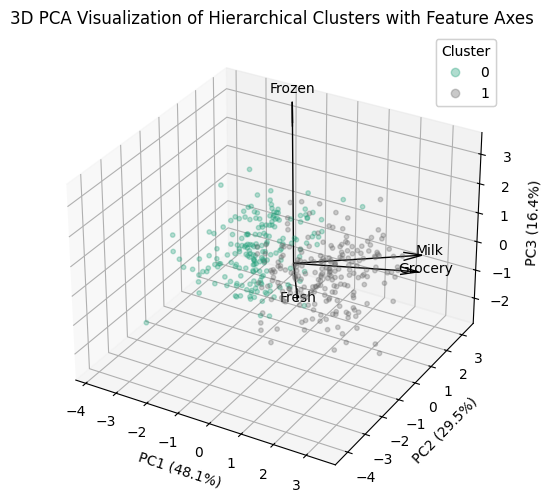

Explained variance by PC1, PC2, and PC3: [0.48130121 0.29529157 0.16440054]


In [47]:
# --- Perform PCA with 3 components for 3D visualization ---
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_scaled)

# --- 3D Scatter Plot for Hierarchical Clustering Results ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot cluster points
scatter = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=df_clean['HierCluster'],
    cmap='Dark2',
    s=10,
    alpha=0.3
)

# --- Plot Feature Axes (Loadings) ---
features = ['Fresh', 'Milk', 'Grocery', 'Frozen']
loadings = pca.components_.T  # (4 x 3 matrix)
scaling_factor = 5  # adjust arrow length

for i, feature in enumerate(features):
    ax.quiver(
        0, 0, 0,
        loadings[i, 0] * scaling_factor,
        loadings[i, 1] * scaling_factor,
        loadings[i, 2] * scaling_factor,
        color='black', arrow_length_ratio=0.15, linewidth=1
    )
    ax.text(
        loadings[i, 0] * (scaling_factor + 0.3),
        loadings[i, 1] * (scaling_factor + 0.3),
        loadings[i, 2] * (scaling_factor + 0.3),
        feature, color='black', fontsize=10, ha='center'
    )

# --- Label Axes and Add Legend ---
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('3D PCA Visualization of Hierarchical Clusters with Feature Axes')

legend = ax.legend(*scatter.legend_elements(), title="Cluster", loc="best")
ax.add_artist(legend)

plt.show()

# --- Display Explained Variance ---
print("Explained variance by PC1, PC2, and PC3:", pca.explained_variance_ratio_)


### Hierarchical Cluster Profiling

In [48]:
# Calculate the average spending for each product category within each Hierarchical cluster
df_clean.groupby('HierCluster')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']].mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper
HierCluster,,,,,
0,14775.792746,1988.393782,2889.227979,3877.735751,504.782383
1,7374.421525,7352.044843,10280.502242,1430.224215,3995.130045


In [49]:
# Display raw count of customers from each Channel in each Hierarchical Cluster
pd.crosstab(df_clean['HierCluster'], df_clean['Channel'])


Channel,1,2
HierCluster,,
0,186,7
1,100,123


In [50]:
# Display raw count of customers from each Region in each Hierarchical Cluster
pd.crosstab(df_clean['HierCluster'], df_clean['Region'])

Region,1,2,3
HierCluster,,,
0,36,24,133
1,35,21,167


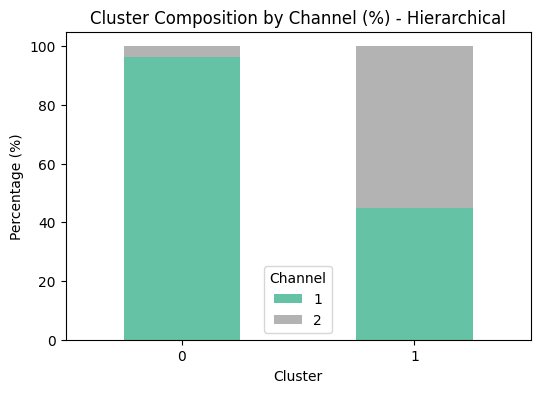

In [51]:
# Compute percentage distribution of Channels within each Hierarchical Cluster
cross_tab_channel = pd.crosstab(df_clean['HierCluster'], df_clean['Channel'], normalize='index') * 100

# Plot the composition of clusters by Channel using a stacked bar chart
cross_tab_channel.plot(kind='bar', stacked=True, figsize=(6,4), colormap='Set2')

# Add plot details
plt.title("Cluster Composition by Channel (%) - Hierarchical")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.legend(title="Channel")
plt.xticks(rotation=0)
plt.show()

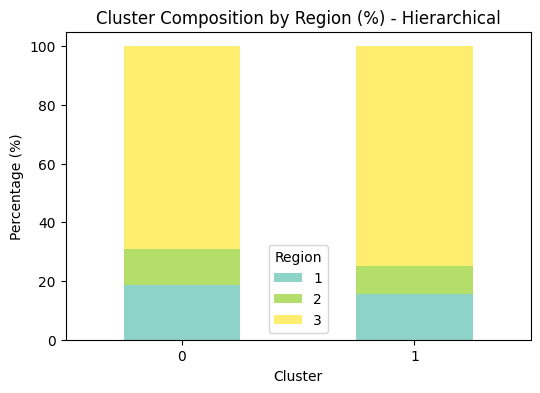

In [52]:
# Compute percentage distribution of Regions within each Hierarchical Cluster
cross_tab_region = pd.crosstab(df_clean['HierCluster'], df_clean['Region'], normalize='index') * 100

# Plot the composition of clusters by Region using a stacked bar chart
cross_tab_region.plot(kind='bar', stacked=True, figsize=(6,4), colormap='Set3')

# Add plot details
plt.title("Cluster Composition by Region (%) - Hierarchical")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.legend(title="Region")
plt.xticks(rotation=0)
plt.show()

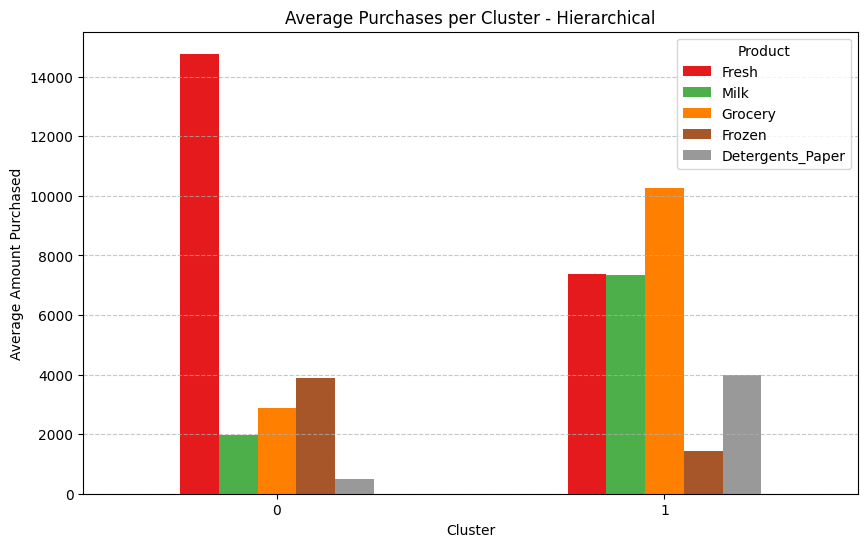

In [53]:
# Compute mean purchase amounts for each product category within every Hierarchical Cluster
cluster_means = df_clean.groupby('HierCluster')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']].mean()

# Plot the average spending per cluster using a grouped bar chart
cluster_means.plot(kind='bar', figsize=(10,6), colormap='Set1')

# Add chart details
plt.title("Average Purchases per Cluster - Hierarchical")
plt.xlabel("Cluster")
plt.ylabel("Average Amount Purchased")
plt.xticks(rotation=0)
plt.legend(title="Product")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

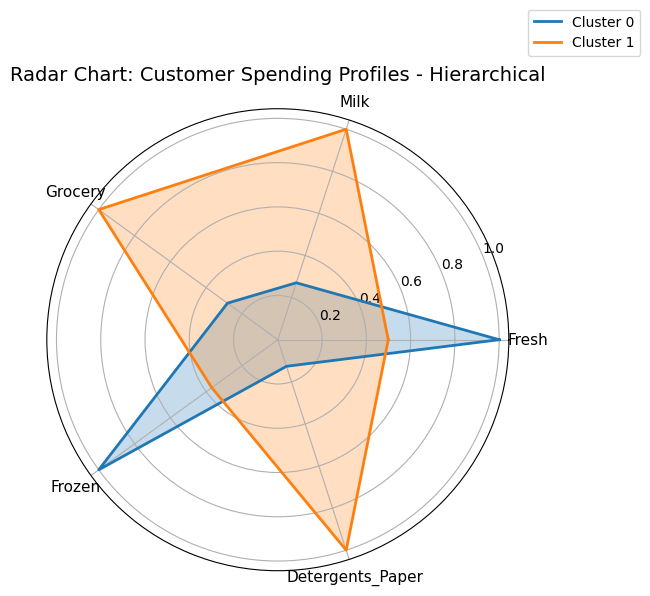

In [54]:
# Compute cluster means
cluster_means = df_clean.groupby('HierCluster')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper']].mean()

# Normalize values to improve shape comparability
cluster_means_norm = cluster_means / cluster_means.max()

# Define labels and number of variables
categories = cluster_means_norm.columns
N = len(categories)

# Calculate angles for each axis
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Create plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster
for i in range(len(cluster_means_norm)):
    values = cluster_means_norm.iloc[i].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

# Add feature labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_title("Radar Chart: Customer Spending Profiles - Hierarchical", size=14, pad=20)
ax.legend(loc='lower right', bbox_to_anchor=(1.3, 1.1))
plt.show()

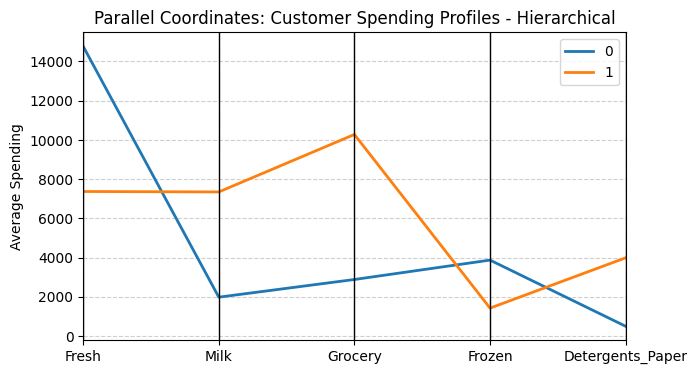

In [55]:
# Prepare data for parallel coordinates
cluster_means_reset = cluster_means.reset_index()
cluster_means_reset['HierCluster'] = cluster_means_reset['HierCluster'].astype(str)

plt.figure(figsize=(7, 4))
parallel_coordinates(
    cluster_means_reset,
    class_column='HierCluster',
    cols=['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper'],
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],
    linewidth=2
)
plt.title("Parallel Coordinates: Customer Spending Profiles - Hierarchical")
plt.ylabel("Average Spending")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Supervised Learning**

### Region Classification using Support Vector Machines (SVM)

In [56]:
# Reuse the preprocessed and aligned data
X_svm = X_scaled
y_svm = region_clean

print(X_svm.shape, y_svm.shape)

(416, 4) (416,)


### Model Training and Fine-tuning using SMOTE and GridSearch CV

In [57]:
# Apply SMOTE to balance class distribution
smote = SMOTE(random_state=42)

# Fit SMOTE on the original data and generate a new, balanced dataset
X_res, y_res = smote.fit_resample(X_svm, y_svm)

In [58]:
# Define SVM model
svc = SVC(probability=True, random_state=42)

In [59]:
#Define the hyperparameter grid for SVM
param_grid = [
    {
        'kernel': ['rbf'],
        'C': [0.1, 1],
        'gamma': [0.001, 0.01, 0.1, 1]
    },
    {
        'kernel': ['linear'],
        'C': [0.01, 0.1, 1, 10, 100]
    }
]

# Set up cross-validation and GridSearchCV
# StratifiedKFold ensures balanced class splits in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV performs exhaustive search over parameter grid using F1-macro score
grid = GridSearchCV(SVC(probability=True, random_state=42),
                    param_grid=param_grid,
                    cv=cv,
                    scoring='f1_macro',
                    n_jobs=-1,
                    verbose=3)

#Train the model using cross-validation
grid.fit(X_res, y_res)

#Display best parameters and F1-macro score
print("Best Parameters:", grid.best_params_)
print("Best F1 Macro:", grid.best_score_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best F1 Macro: 0.7410590766060261


### Metrics Evaluation

In [60]:
# Evaluate best model on the balanced dataset
best_model = grid.best_estimator_
y_pred = best_model.predict(X_res)
y_proba = best_model.predict_proba(X_res)

#Display confusion matrix and classification report
print("\nConfusion Matrix:\n", confusion_matrix(y_res, y_pred))
print("\nClassification Report:\n", classification_report(y_res, y_pred))


Confusion Matrix:
 [[268  13  19]
 [ 13 276  11]
 [ 63  43 194]]

Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.89      0.83       300
           2       0.83      0.92      0.87       300
           3       0.87      0.65      0.74       300

    accuracy                           0.82       900
   macro avg       0.83      0.82      0.82       900
weighted avg       0.83      0.82      0.82       900



### Confusion Matrix Heatmap

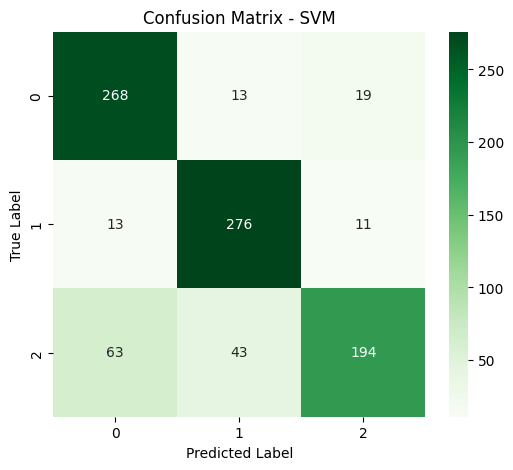

In [61]:
# Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_res, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
#Add titles and labels
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC curves for the Regions and ROC-AUC Metrics

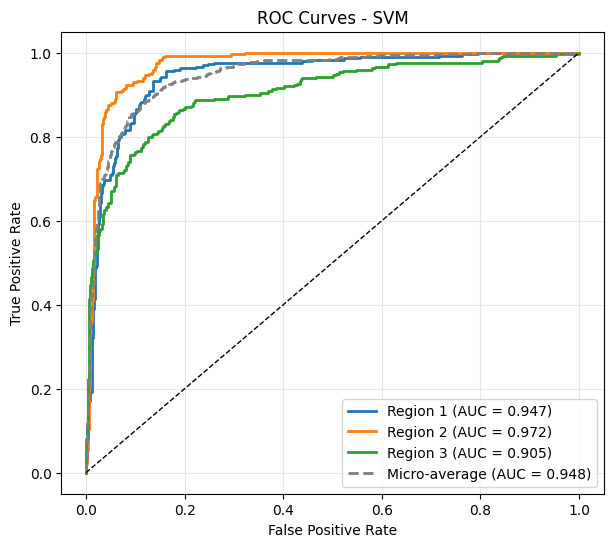


Micro-average AUC: 0.948
Macro-average AUC: 0.941


In [62]:
# Compute ROC Curves and AUC for each class
classes = sorted(np.unique(y_res))  # Get all unique class labels (Regions)
y_bin = label_binarize(y_res, classes=classes)  # Convert labels to one-hot encoding for multiclass ROC

# Initialize dictionaries to store ROC and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

# Compute ROC curve and AUC per class
for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# Compute micro-average ROC (overall performance)
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC (mean AUC across classes)
roc_auc_macro = roc_auc_score(y_bin, y_proba, average='macro')

# Plot ROC Curves
plt.figure(figsize=(7,6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot each class curve with its AUC score
for i, cls in enumerate(classes):
    plt.plot(fpr[cls], tpr[cls], color=colors[i], lw=2, label=f'Region {cls} (AUC = {roc_auc[cls]:.3f})')

# Add micro-average ROC curve (dashed)
plt.plot(fpr_micro, tpr_micro, color='grey', lw=2, linestyle='--', label=f'Micro-average (AUC = {roc_auc_micro:.3f})')

# Add diagonal reference line for random classifier
plt.plot([0,1],[0,1],'k--', lw=1)

# Label and format plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - SVM')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Print overall evaluation metrics
print("\nMicro-average AUC:", round(roc_auc_micro,3))
print("Macro-average AUC:", round(roc_auc_macro,3))